In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt

% matplotlib inline

np.random.seed(0)
random.seed(0)
pd.set_option('display.max_colwidth', -1)

## Loading Data

In [67]:
data = pd.read_csv('../input/train.tsv', sep='\t')
data.sample(10).head(10)

,PhraseId,SentenceId,Phrase,Sentiment
21923,21924,980,escape movie,2
18206,18207,795,well-executed,4
81802,81803,4221,flick formula,2
114982,114983,6124,is too savvy a filmmaker to let this morph into a typical romantic triangle .,3
135927,135928,7343,"There are laughs aplenty ,",4
93841,93842,4895,easy to forgive because the intentions are lofty,2
93497,93498,4875,snow-and-stuntwork extravaganza,3
7460,7461,303,own game,2
133296,133297,7192,teen life,2
149073,149074,8111,are doing,2


In [68]:
train = data[['PhraseId','SentenceId','Phrase']]
labels = data[['Sentiment']]

print('train shape', train.shape)
print('label shape', labels.shape)

train shape (156060, 3)
label shape (156060, 1)


## Preprocessing

To clean our text data we perform the following actions:

1. Lower case the review
2. Split on spaces
3. For each word:
  1. Replace contractions with their full word (ie `n't` becomes `not`)
  2. Remove words starting with a number
  3. Remove any words that contain no letters

In [69]:
# preprocess text data
import re

def preprocess(text):
    words = []
    split = re.compile(r"[^a-z0-9']")
    digit = re.compile(r'^\d')
    alpha = re.compile(r'[a-z]')
    
    contractions = {
        "n't": 'not',
        "'d": 'would',
        "'re": 'are',
        "'ll": 'will',
        "'s": 'has',
        "'m": 'am',
        "'ve": 'have'
    }
    
    for w in split.split(text.lower()):
        if w.isspace():
            continue
        if w == '':
            continue
        if w in contractions:
            w = contractions[w]

        if digit.match(w):
            w = '<digit>'
        elif not alpha.match(w):
            continue

        words.append(w)
            
    return ' '.join(words)

In [70]:
train['CleanedPhrase'] = train['Phrase'].apply(preprocess)
train.sample(10).head(10)

,PhraseId,SentenceId,Phrase,CleanedPhrase
31257,31258,1460,the intelligent jazz-playing exterminator,the intelligent jazz playing exterminator
124276,124277,6674,funny bones tickled,funny bones tickled
33247,33248,1558,"Ram Dass Fierce Grace moulds itself as an example to up-and-coming documentarians , of the overlooked pitfalls of such an endeavour .",ram dass fierce grace moulds itself as an example to up and coming documentarians of the overlooked pitfalls of such an endeavour
85842,85843,4443,Your appreciation of it,your appreciation of it
102718,102719,5411,talk to and about others,talk to and about others
58417,58418,2943,mesmerize,mesmerize
72261,72262,3693,lively songs,lively songs
83633,83634,4322,propulsive,propulsive
55073,55074,2745,Pull -LRB- s -RRB- off the rare trick of recreating not only,pull lrb s rrb off the rare trick of recreating not only
8320,8321,345,raises the film above anything Sandler 's been attached to before,raises the film above anything sandler has been attached to before


### Splitting the Data
Our dataset only includes a single dataset so we must split data into train, test, and validation datasets.

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)

y_train = y_train['Sentiment'].values
y_test = y_test['Sentiment'].values
y_val = y_val['Sentiment'].values

n_classes = len(np.unique(y_train))

print('Classes: ', n_classes)
print('Training size: %s, %s' % (X_train.shape, y_train.shape))
print('Testing size: %s, %s' % (X_test.shape, y_test.shape))
print('Validation size: %s, %s' % (X_val.shape, y_val.shape))

Classes:  5
Training size: (124848, 4), (124848,)
Testing size: (15606, 4), (15606,)
Validation size: (15606, 4), (15606,)


#### Class Distribution
We have 5 classes, but the distributions are very uneven so we must figure out what weights we want to apply to the underrepresented classes.

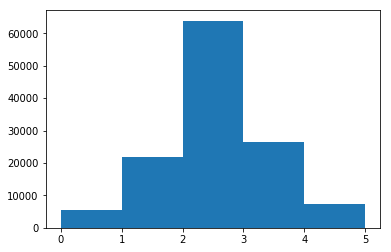

In [72]:
plt.hist(y_train, bins=[0,1,2,3,4,5])
plt.show()

In [73]:
def calculate_class_weights(labels):
    counts = np.bincount(labels)
    largest = np.max(counts)

    w = {}
    for label, count in enumerate(counts):
        w[label] = largest/count

    print('Weights:')
    for cls, weight in w.items():
        print('%d: %0.6f' % (cls, weight))

weights = calculate_class_weights(y_train)

Weights:
0: 11.383779
1: 2.938797
2: 1.000000
3: 2.424748
4: 8.741172


## Training

In [78]:
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers import *
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [75]:
# helper functions for training

def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    
    # Plot training & validation accuracy values
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('Model %s accuracy' % name)
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model %s loss' % name)
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
    
def train_model(name, model,
                x_train, y_train, x_test, y_test, x_val, y_val,
                batch_size=32,
                epochs=10,
                callbacks=[],
                class_weight=weights,
                categorical=True,
                initial_epoch=0,
                save=True):
    if categorical:
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        y_val = to_categorical(y_val)
        
    history = model.fit(x_train,
          batch_size=batch_size, 
          y=y_train,
          verbose=1,
          shuffle=True, 
          epochs=epochs, 
          validation_data=(x_test, y_test),
          class_weight=class_weight,
          callbacks=callbacks,
          initial_epoch=initial_epoch)

    if save:
        model.save('%s.h5' % name)
        
    plot_history(history, name)
    scores = model.evaluate(x_val, y_val)

    print('validation scores for %s' % name)
    for i, score in enumerate(scores):
        name = model.metrics_names[i]
        print('%s score: %0.6f' % (name, score))
    
    return history

def create_sequences(tokenizer, *inputs, **kwargs):
    maxlen = kwargs.get('maxlen', seq_max_length)
    padding = kwargs.get('padding', 'pre')
    fit = kwargs.get('fit', True)
    
    if fit:
        tokenizer.fit_on_texts(inputs[0])
    
    seqs = []
    for input in inputs:
        seq = tokenizer.texts_to_sequences(input)
        seq = pad_sequences(seq, maxlen=maxlen, padding=padding)
        seqs.append(seq)
    
    return seqs

#### Creating the Input

Since the data we are working with is text, we must convert the text to numbers before the neural network can process it. To do this, we use a `Tokenizer` which splits reviews into individual words. This process creates a unique identifier per word that we use to create a sequence which is what is passed into the neural network. Each sequence must be the same length so we pad each review with `0`s if they are shorter than our specified length (`50`).

In [76]:
seq_max_length=50

# tokenizer splits reviews into individual tokens (words)
tokenizer = Tokenizer(filters='', lower=True)

# create a sequence from each data set
(train_seq, test_seq, val_seq) = create_sequences(tokenizer,
                                                  X_train['CleanedPhrase'],
                                                  X_test['CleanedPhrase'], 
                                                  X_val['CleanedPhrase'],
                                                  padding='post', fit=True)

print('Train shape:', train_seq.shape)
print('Test shape:', test_seq.shape)
print('Validation shape:', val_seq.shape)

Train shape: (124848, 50)
Test shape: (15606, 50)
Validation shape: (15606, 50)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 32)            483872    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 32)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 10)            1560      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 48, 128)           3968      
_________________________________________________________________
activation_11 (Activation)   (None, 48, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 47, 64)            16448     
__________

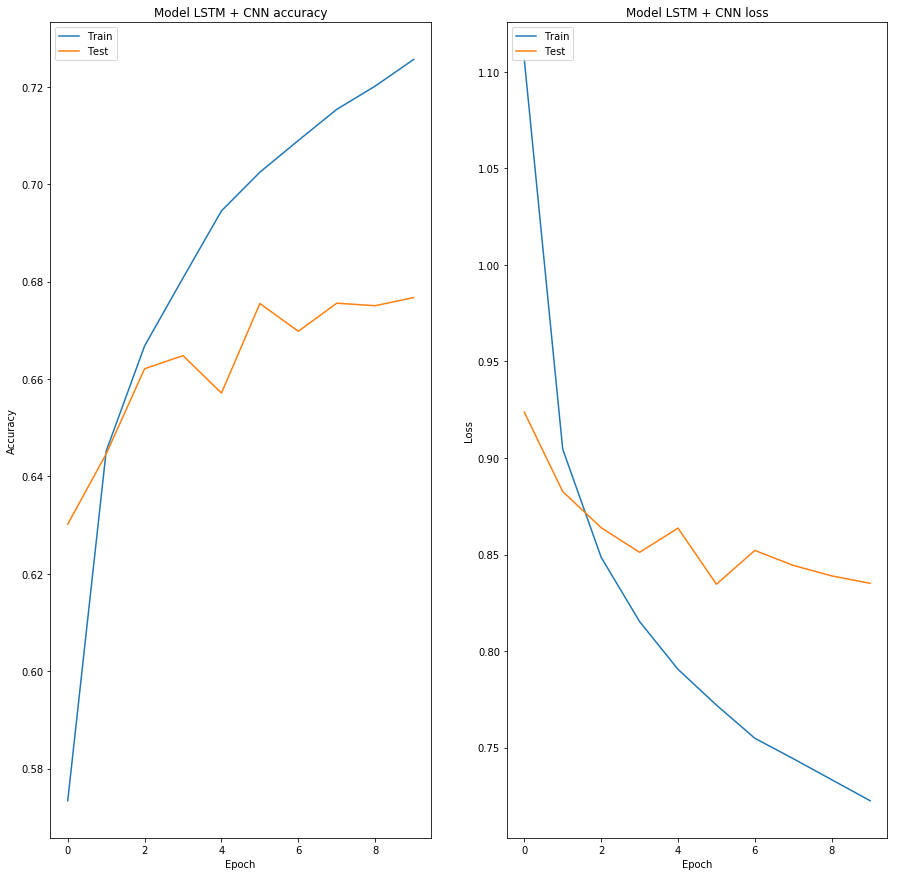

In [79]:
def build_model(vocab_size,
                   seq_length,
                   embedding_dims=32,
                   embedding_matrix=None,
                   n_classes=n_classes,
                   rnn_units=128,
                   loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc']):
    inputs = Input(shape=(seq_length,))
    
    x = Embedding(vocab_size,
                  embedding_dims,
                  input_length=seq_length)(inputs)
    x = SpatialDropout1D(0.2)(x)
    
    x = Bidirectional(CuDNNLSTM(rnn_units, return_sequences=True))(x)    
    x = Conv1D(128, kernel_size=3)(x)
    x = Activation('relu')(x)
    
    x = Conv1D(64, kernel_size=2)(x)
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=2)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation = 'softmax')(x)

    model = Model(inputs=[inputs], outputs=x)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
    
    return model

model = build_model(len(tokenizer.word_index),
                        seq_max_length,
                        rnn_units=5)
model.summary()

filepath="model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

train_model('LSTM + CNN', model, 
            train_seq, y_train, test_seq, y_test, val_seq, y_val,
            callbacks=[checkpoint],
            class_weight=weights,
            epochs=10,
            batch_size=25,
            save=False)

In [80]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Prediction

In [82]:
def evaluate(text):
    t = preprocess(text)
    df = pd.DataFrame([[t]], columns=['text'])
    
    seq = create_sequences(tokenizer, df.text, maxlen=50, padding='post', fit=False)
    output = model.predict(seq)
    cls = np.argmax(output)
    desc =  ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'][cls]
    print('"%s": %s' % (text, desc))
    
evaluate('This movie had a lot of humor and it made me laught the entire time!')
evaluate("The plot of this movie was lacking and I really did not enjoy it.")

"This movie had a lot of humor and it made me laught the entire time!": somewhat positive
"The plot of this movie was lacking and I really did not enjoy it.": somewhat negative
